# 데모

## 라이브러리 import 및 설정

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
import seaborn as sns
import warnings
import re

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

In [32]:
data_dir = Path('./open')
val_dir = Path('./ensemble/build/val')
tst_dir = Path('./ensemble/build/tst')
sub_dir = Path('./open/sub')

trn_file = data_dir / 'train_processed_500.csv'
tst_file = data_dir / 'test_x.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'author'
n_fold = 5
n_class = 5
seed = 42

In [34]:
algo_name = 'lr'
feature_name = 'tfidf'
model_name = f'{algo_name}_{feature_name}'

p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [6]:
train = pd.read_csv(trn_file, index_col=0)
print(train.shape)
train.head()

(183468, 3)


,text,author,length
index,,,
0,He was almost choking. There was so much so mu...,3,235
1,Your sister asked for it I suppose,2,34
2,She was engaged one day as she walked in peru...,1,312
3,The captain was in the porch keeping himself c...,4,305
4,Have mercy gentlemen odin flung up his hands. ...,3,215


In [7]:
test = pd.read_csv(tst_file, index_col=0)
print(test.shape)
test.head()

(19617, 1)


,text
index,
0,“Not at all. I think she is one of the most ch...
1,"""No,"" replied he, with sudden consciousness, ""..."
2,As the lady had stated her intention of scream...
3,“And then suddenly in the silence I heard a so...
4,His conviction remained unchanged. So far as I...


<h2> 문자열 전처리

In [8]:
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)


def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)


stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [10]:

train['text'] = train['text'].str.lower().apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].str.lower().apply(alpha_num).apply(remove_stopwords)

In [11]:
idx_under_20 = train[train['length'] < 20].index
train = train.drop(idx_under_20)
train = train.reset_index()
train.describe()

,index,author,length
count,181013.0000,181013.0000,181013.0000
mean,91514.5870,2.0491,164.5379
std,53025.4182,1.2863,178.6952
min,0.0000,0.0000,20.0000
25%,45490.0000,1.0000,65.0000
50%,91441.0000,2.0000,113.0000
75%,137458.0000,3.0000,189.0000
max,183467.0000,4.0000,2454.0000


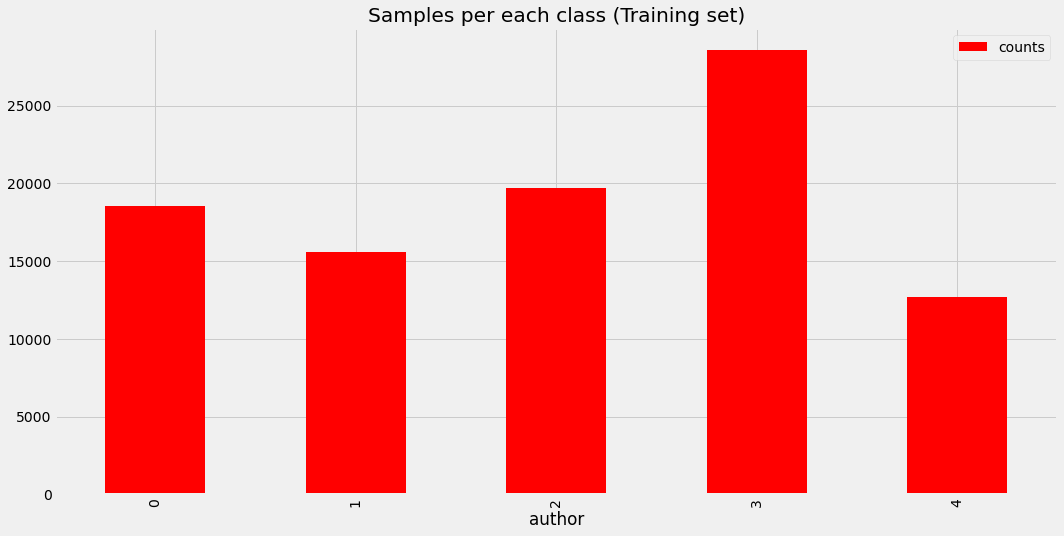

In [12]:
df = train.drop_duplicates(['text'])
df.groupby(df.author).size().reset_index(name="counts").plot.bar(x='author',title="Samples per each class (Training set)",color='red')

In [13]:

df = df.reset_index()
df['index'] = df['index'].reset_index()

In [14]:
train = df
train= train.drop(columns=['level_0'])
train

,index,text,author,length
0,0,almost choking much much wanted say strange ex...,3,235
1,1,sister asked suppose,2,34
2,2,engaged one day walked perusing janes last let...,1,312
3,3,captain porch keeping carefully way treacherou...,4,305
4,4,mercy gentlemen odin flung hands dont write an...,3,215
...,...,...,...,...
95080,95080,diningroom soon joined odin odin busily engage...,1,150
95081,95081,one came books toilette,1,56
95082,95082,faces however tolerably calm no change visible...,1,252
95083,95083,still ticking hall,2,29


In [15]:
trn = train['text'].values
tst = test['text'].values
y = train['author'].values
print(trn.shape, tst.shape, y.shape)

(95085,) (19617,) (95085,)


## NLTK Lemmatization 

In [16]:
import nltk
#nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:

lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in word_tokenize(text)]

train['text'] = train['text'].apply(lemmatize_text)
test['text'] = test['text'].apply(lemmatize_text)

In [18]:
def to__string(text):
    return ' '.join(text)

train['text'] = train['text'].apply(to__string)
test['text'] = test['text'].apply(to__string)

## Bag-of-Words 피처 생성

In [20]:
vec = CountVectorizer(tokenizer=word_tokenize, ngram_range=(1, 2), min_df=100)
X_cnt = vec.fit_transform(train['text'])
print(X_cnt.shape)

(95085, 2549)


In [21]:
X_cnt[0, :50].todense()

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [24]:
vec = TfidfVectorizer(tokenizer=word_tokenize, ngram_range=(1, 3), min_df=50)
X = vec.fit_transform(train['text'])
X_tst = vec.transform(test['text'])
print(X.shape, X_tst.shape)

(95085, 4757) (19617, 4757)


In [25]:
X[0, :50].todense()

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])

## 로지스틱회귀 모델 학습

In [26]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [27]:
y = train.author.values
y.shape

(95085,)

In [28]:
p = np.zeros((X.shape[0], n_class))
p_tst = np.zeros((X_tst.shape[0], n_class))
for i_cv, (i_trn, i_val) in enumerate(cv.split(X, y), 1):
    clf = LogisticRegression()
    clf.fit(X[i_trn], y[i_trn])
    p[i_val, :] = clf.predict_proba(X[i_val])
    p_tst += clf.predict_proba(X_tst) / n_class

In [29]:
print(f'Accuracy (CV): {accuracy_score(y, np.argmax(p, axis=1)) * 100:8.4f}%')
print(f'Log Loss (CV): {log_loss(pd.get_dummies(y), p):8.4f}')

Accuracy (CV):  67.7604%
Log Loss (CV):   0.8724


In [35]:
np.savetxt(p_val_file, p, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 제출 파일 생성

In [ ]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

In [ ]:
sub[sub.columns] = p_tst
sub.head()

In [ ]:
sub.to_csv(sub_file)